Here we plot the high dimensional feature space and color-code based on prolate vs. not classification using two crieteria.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.lines import Line2D
import os
import pickle
import pandas as pd

In [2]:
fontsize = 18
rcparams = {}
rcparams['figure.figsize'] = (10, 6)
rcparams['axes.labelsize'] = fontsize
rcparams['legend.fontsize'] = fontsize-4
rcparams['axes.titlesize'] = fontsize
rcparams['axes.linewidth'] = 2
rcparams['axes.grid'] = True
for axis in ['x', 'y']:
    rcparams['%stick.labelsize'%axis] = fontsize-2
    rcparams['%stick.direction'%axis] = 'in'
    rcparams['%stick.major.size'%axis] = 5.5
    rcparams['%stick.minor.size'%axis] =  3.5
    rcparams['%stick.major.width'%axis] = 2
    rcparams['%stick.minor.width'%axis] = 1.5
rcparams['xtick.top'] = True
rcparams['ytick.right'] = True
for key in rcparams: mpl.rcParams[key] = rcparams[key]

In [3]:
from sklearn.manifold import TSNE
from matplotlib.ticker import NullFormatter
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

Set up a function to plot things out

In [4]:
def plot_highd_data(features, targets, title, ):
    # will look for P and not-P in trrgets
    n_components=2
    # get results
    tsne = TSNE(n_components=n_components, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(features)

    df_subset = pd.DataFrame()
    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
    df_subset['shape'] = targets
    # plot 2d project
    plt.figure(figsize=(8,8))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="shape",
        palette=sns.color_palette("hls", n_components),
        data=df_subset,
        legend="full",
    )
    plt.suptitle(title, fontsize=16, y=0.92)
    plt.show()
    
    # plot 3d project
    hue = np.array( len( targets ) * ['r'] )
    hue[ targets == 'Not-P' ] = 'g'

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(*zip(*tsne_results), color=hue)
    plt.suptitle(title, fontsize=16, y=0.85)
    plt.show()

Now read in the data

In [5]:
features_file='/Users/humnaawan/repos/3D-galaxies-kavli/data/tng_highres/xy/features_28.csv'
shape_datapath='/Users/humnaawan/repos/3D-galaxies-kavli/outputs/tng-100/'

In [6]:
# features
feats = pd.read_csv(features_file)
feats.keys()

Index(['aper_ba', 'delM_10_20', 'delM_20_39', 'delM_39_77', 'delM_77_107',
       'delM_107_150', 'dele_10_22', 'delpa_10_22', 'dele_22_37',
       'delpa_22_37', 'dele_37_77', 'delpa_37_77', 'dele_77_111',
       'delpa_77_111', 'dele_111_160', 'delpa_111_160', 'a1_10', 'a4_10',
       'a1_22', 'a4_22', 'a1_37', 'a4_37', 'a1_77', 'a4_77', 'a1_93', 'a4_93',
       'e_93', 'logm100'],
      dtype='object')

Now read in the shape data based on hongyu's criteria

In [7]:
file = [ f for f in os.listdir(shape_datapath) if f.startswith('shape100_')][0]
with open('%s/%s' % (shape_datapath, file), 'rb') as f:
    shape = pickle.load(f)
shape_data_0 = pd.DataFrame({ 'shape': np.array( shape['shape'] ) } )
shape_data_0['shape'][ shape_data_0['shape'] != 'P' ] = 'Not-P'

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 295 samples in 0.001s...
[t-SNE] Computed neighbors for 295 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 295 / 295
[t-SNE] Mean sigma: 8.543668
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.553207
[t-SNE] KL divergence after 300 iterations: 0.997058


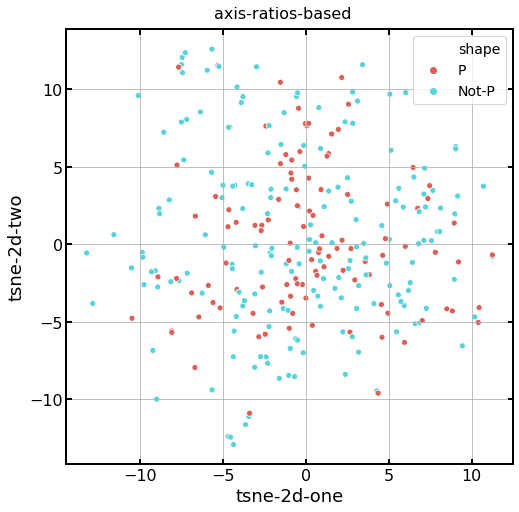

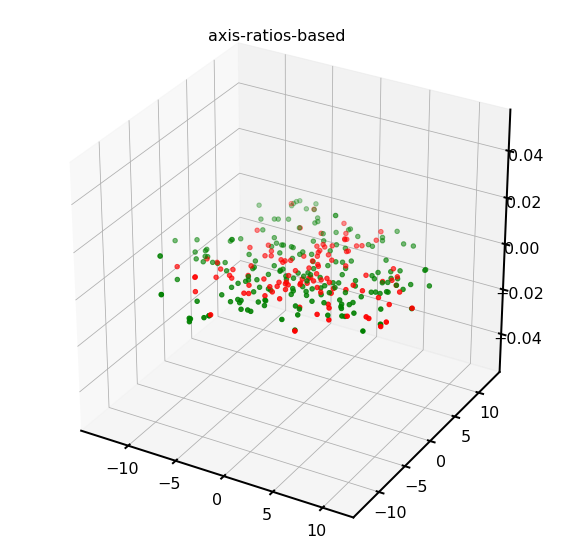

In [8]:
plot_highd_data(features=feats.values, targets=shape_data_0['shape'].values, title='axis-ratios-based', )

T-based data

In [9]:
regress = False
triaxiality_based = True
Rstar = 100
shape_data = {}
# loop over the local foders; each folder is for a specific halo
for i, folder in enumerate([f for f in os.listdir(shape_datapath) if f.startswith('TNG')]):
    # ---------------------------------------------------------------------
    # now read in the data
    file = [ f for f in os.listdir('%s/%s' % (shape_datapath, folder)) if f.startswith('shape_')][0]
    with open('%s/%s/%s' % (shape_datapath, folder, file), 'rb') as f:
        data_now = pickle.load(f)
    # add triaxiality
    data_now['T'] = (1 -  data_now['b/a'] ** 2 ) / (1 -  data_now['c/a'] ** 2 )
    # find value specified rstar
    ind = np.where( data_now['Rstar'] == Rstar )[0]
    if i == 0:
        if not triaxiality_based:
            shape_data['b/a_%s' % Rstar] = [ data_now['b/a'][ind] ]
            shape_data['c/a_%s' % Rstar] = [ data_now['c/a'][ind] ]
        shape_data['T_%s' % Rstar] = [ data_now['T'][ind] ]
    else:
        if not triaxiality_based:
            shape_data['b/a_%s' % Rstar] += [ data_now['b/a'][ind] ]
            shape_data['c/a_%s' % Rstar] += [ data_now['c/a'][ind] ]
        shape_data['T_%s' % Rstar] += [ data_now['T'][ind] ]
for key in shape_data:
    shape_data[key] = np.array(shape_data[key]).flatten()
# asseble classification based on triaxiality
if not regress:
    shape_class = {}
    shape_class['shape'] = np.empty_like( shape_data['T_%s' % Rstar] ).astype(str)
    shape_class['shape'][:] = 'Not-P'
    shape_class['shape'][ shape_data['T_%s' % Rstar] > 0.7] = 'P'
    shape_data = shape_class
shape_data = pd.DataFrame( shape_data )

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 295 samples in 0.001s...
[t-SNE] Computed neighbors for 295 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 295 / 295
[t-SNE] Mean sigma: 8.543668
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.917831
[t-SNE] KL divergence after 300 iterations: 0.953167


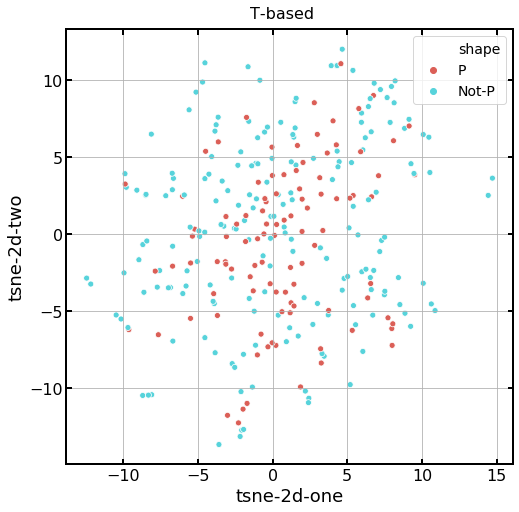

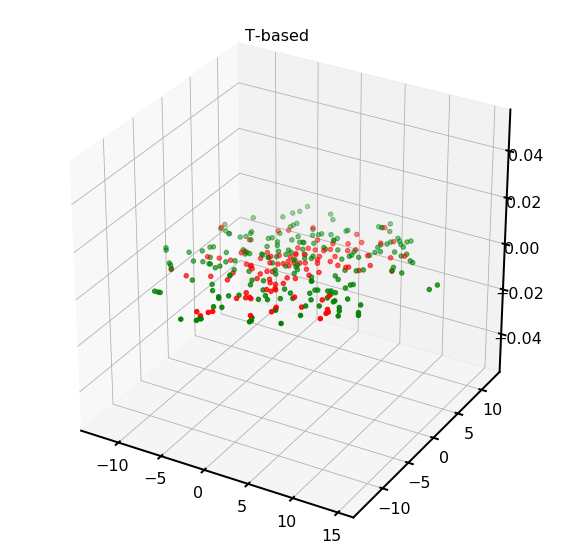

In [10]:
plot_highd_data(features=feats.values, targets=shape_data['shape'].values, title='T-based', )